In [1]:
import numpy as np
import random
import json 
import cv2
import yaml
import matplotlib.pyplot as plt

from numpy.linalg import norm
from scipy.spatial.transform import Rotation
from scipy.linalg import pinv, inv, lstsq

## Read dataset and camera parameters

In [2]:
def read_dataset(filename: str):
    """
    Read json-file which contains image information:
    1) Camera rotation, camera position
    2) Image key points
    """
    dataset_file = open(filename)
    dataset_json = dataset_file.read()
    data = json.loads(dataset_json)
    return data

In [3]:
def read_camera_intrinsic_params(filename: str):
    """
    Read yaml-file which contains camera intrinsic params:
    1) intrinsic matrix: focal lengths, etc.
    2) distortion coefficients
    """
    with open(filename) as stream:
        camera_data = (yaml.safe_load(stream))

    M = np.array(camera_data["camera_matrix"])
    distortion = np.array(camera_data["dist_coeff"])
    return M, distortion

In [4]:
data = read_dataset('dataset.json')
M, distortion = read_camera_intrinsic_params("calibration.yaml")

In [ ]:
distortion

In [ ]:
M

In [ ]:
data

## Some useful function for back projection

In [18]:
def rotation_vec_to_matrix(rvec):
    rotation_object = Rotation.from_rotvec(rvec)
    return rotation_object.as_matrix()

In [19]:
def concat_R_and_t(R, t): 
    return np.hstack([R, t])

In [5]:
def get_P(M, rvec, tvec):
    R = rotation_vec_to_matrix(rvec)
    Rt = concat_R_and_t(R, tvec)
    return np.dot(M, Rt)

In [6]:
def get_C_hat(P):
    """
    Get optical camera center by formula: $C_hat$ = -P[3x3]^-1 * P[4] 
    """
    p_hat = P[:, 0:3]
    p4 = P[:,3]
    C = - np.dot(inv(p_hat), p4)
    return np.append(C, 1)

In [7]:
def get_point_on_ray(P, point, C, lamda): # Здесь не lambda, потому что это зарезервированное имя питоном
    return np.dot(pinv(P), point) + lamda * C

In [8]:
def homo_to_euclid(point):
    point = point / point[-1]
    return point[:-1]

In [113]:
def project_3d_to_2d(rvec, tvec, M, point):
    points_2d, _ = cv2.projectPoints(point, 
                                 rvec, -tvec, 
                                 M, 
                                 None)
    
    return points_2d

## Algo functions

In [10]:
def to_plane(pointA, pointB, pointC, debug_mode = False):
    """
    Get plane Ax + By + Cz + D = 0 using 3 points in 3D, where a normal = (A, B, C) 
    """
    AB = pointB - pointA
    AC = pointC - pointA

    normal = np.cross(AB, AC)
    D = -np.dot(normal, pointA)

    plane = np.zeros((1, 4))
    plane[:,:3] = normal/normal[0]
    plane[0,3] = D/normal[0]
    # return normal[0]/normal[0], normal[1]/normal[0], normal[2]/normal[0], D/normal[0], \
    return plane

## Visualization functions

In [95]:
def print_point_in_image(points, img_path, name_suffix='result', radius=1):
    img = cv2.imread(img_path)
    for point in points:
        img = cv2.circle(img, (int(point[0]), int(point[1])), radius=radius, color=(0, 0, 255), thickness=-1)
    cv2.imwrite(f"{img_path}-{name_suffix}.png", img)

## Full process

In [12]:
def get_image_info(data, filename: str):
    img_data = data[filename]
    
    rvec = np.array(img_data["rvec"], dtype='float32')
    rvec = rvec.reshape(3)
    
    tvec = np.array(img_data["tvec"], dtype='float32')
    
    return img_data, rvec, tvec

In [13]:
def get_image_point(img_data, point_index):
    return np.array(img_data["points"][point_index][0])

In [14]:
def to_homo(point2D):
    point3D = np.append(point2D, 1)
    return point3D

## Example for 1 point and 1 camera of dataset

### Getting info from dataset

In [15]:
img_data, rvec, tvec = get_image_info(data, "GOPR0039.JPG")

In [16]:
point1 = get_image_point(img_data, 0)

In [20]:
P = get_P(M, rvec, tvec)
C = get_C_hat(P)
ray_point = get_point_on_ray(P, to_homo(point1), C, 10)

In [21]:
point1_projection = project_3d_to_2d(rvec, tvec, M, homo_to_euclid(ray_point))

In [22]:
point1

array([2114.98266602, 2402.27075195])

### Error of reprojection

In [23]:
norm(point1_projection - point1)

2.022889806641761e-10

## Algo test

### Get first ray info

In [24]:
ray_point1 = homo_to_euclid(get_point_on_ray(P, to_homo(point1), C, 0))
ray_point2 = homo_to_euclid(get_point_on_ray(P, to_homo(point1), C, 10))

In [25]:
plane1 = to_plane(ray_point1, ray_point2, np.array([0, 0, 1]))
plane2 = to_plane(ray_point1, ray_point2, np.array([1, 1, 0]))

### Get another img info for second ray

In [26]:
img_data, rvec, tvec = get_image_info(data, "GOPR0043.JPG")
P = get_P(M, rvec, tvec)
C = get_C_hat(P)

point1_other_img = get_image_point(img_data, 0)

In [27]:
ray_point1_other_img = homo_to_euclid(get_point_on_ray(P, to_homo(point1_other_img), C, 0))
ray_point2_other_img = homo_to_euclid(get_point_on_ray(P, to_homo(point1_other_img), C, 10))

In [28]:
plane3 = to_plane(ray_point1_other_img, ray_point2_other_img, np.array([0, 0, 1]))
plane4 = to_plane(ray_point1_other_img, ray_point2_other_img, np.array([1, 1, 0]))

### Forming the lin eq system

In [29]:
Ab = np.vstack((plane1, plane2, plane3, plane4))

In [30]:
b = Ab[:,3]
A = np.delete(Ab, 3, 1) 

In [31]:
point_3d, res, rnk, s = lstsq(A, b)

### Get third img to calculate error and get visualization

In [32]:
img_data, rvec, tvec = get_image_info(data, "GOPR0045.JPG")
# We need only 2d point, rvec and tvec 
point1_for_comparing = get_image_point(img_data, 0)

In [33]:
point_in_image = project_3d_to_2d(rvec, tvec, M, point_3d)

### Error of reprojection

In [34]:
norm(point1_for_comparing - point_in_image)

0.5815534751106599

### Visualization

In [ ]:
img_name = "GOPR0045.JPG"
print_point_in_image(point_in_image.tolist()[0][0], f"dataset/{img_name}", radius=1)

In [98]:
for pic in data:
    print_point_in_image(np.array(data[pic]['points']).reshape(-1, 2), f"dataset/{pic}", 'original_dataset_points')

## For k pair of images

### Read dataset

In [35]:
data = read_dataset('dataset.json')
M, distortion = read_camera_intrinsic_params("calibration.yaml")

In [36]:
def get_random_keys(keys, k, with_test = True):
    """Выбирает случайным образом k ключей из словаря dict_keys и одно значение для сравнения.

    Args:
    dict_keys: Ключи словаря с названиями файлов.
    k: Количество пар ключей для выбора.

    Returns:
    Список из k случайных ключей и одно значение для сравнения.
    """

    # Создаем список ключей.
    keys = list(keys)
    to_compare_value = None

    if not with_test:
        # Выбираем случайное значение для исключения.
        to_compare_value = random.choice(keys)

        # Удаляем исключенное значение из списка.
        keys.remove(to_compare_value)

    # Выбираем случайным образом 2*k ключей, исключая исключенное значение.
    random_keys = random.sample(keys, k)

    # Возвращаем список ключей и значение для сравнение
    return random_keys, to_compare_value

In [176]:
def find_3d_point(data, filenames, point_index):
    planes = []
    M, distortion = read_camera_intrinsic_params("calibration.yaml")
    for filename in filenames:
        img_data, rvec, tvec = get_image_info(data, filename)
        P = get_P(M, rvec, tvec)
        C = get_C_hat(P)

        point = get_image_point(img_data, point_index)

        ray_point1 = homo_to_euclid(get_point_on_ray(P, to_homo(point), C, 0))
        ray_point2 = homo_to_euclid(get_point_on_ray(P, to_homo(point), C, 10))
        
        # Создать случайный вектор с размерами 3
        random_point1 = np.random.rand(3)
        random_point2 = np.random.rand(3)        

        plane1 = to_plane(ray_point1, ray_point2, random_point1)
        plane2 = to_plane(ray_point1, ray_point2, random_point2)
        
        planes.append(plane1)
        planes.append(plane2)

    Ab = np.vstack(planes)
    b = Ab[:,3]
    A = np.delete(Ab, 3, 1) 
    point_3d, res, rnk, s = lstsq(A, b)
    return point_3d

## For point №0 find 3D point with k images and compare with other image this point using repojection error

In [42]:
try_count = 100
stats = {}

point_index = 0
for k in range(2, len(data)):
    stats[k]=[]    
    for i in range(try_count):
        filenames, to_compare_filename = get_random_keys(data.keys(), k, False)
        point_3d = find_3d_point(data, filenames, point_index)
        
        img_data, rvec, tvec = get_image_info(data, to_compare_filename)
        # We need only 2d point, rvec and tvec 
        point_for_comparing = get_image_point(img_data, point_index)
        
        point_in_image = project_3d_to_2d(rvec, tvec, M, point_3d)
        
        error = norm(point_for_comparing - point_in_image)
        
        stats[k].append(error)


### Plot a graph 

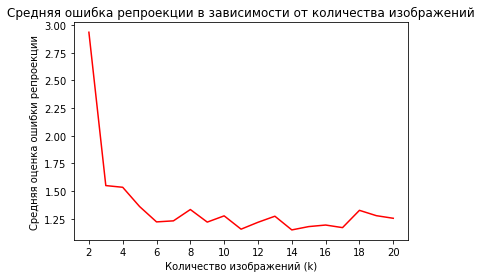

In [43]:
image_count_in_algo = list(stats.keys())
mean_error_values = [sum(value) / len(value) for value in stats.values()]

plt.rcParams["figure.figsize"] = (6,4)

# Создайте график
plt.plot(image_count_in_algo, mean_error_values, 'r')
plt.xlabel("Количество изображений (k)")
plt.ylabel("Средняя оценка ошибки репроекции")
plt.title("Средняя ошибка репроекции в зависимости от количества изображений")
plt.xticks(np.arange(min(image_count_in_algo), max(image_count_in_algo)+1, 2.0)) 

# Отобразите график
plt.show()

## For each points find 3D point with k images and compare with other image this point using repojection error

In [177]:
try_count = 50
stats = {}
points_count = len(data[list(data.keys())[0]]['points'])
for point_index in range(points_count):
    stats[point_index] = {}
    for k in range(2, len(data)):
        stats[point_index][k]= []
        for i in range(try_count):
            filenames, to_compare_filename = get_random_keys(data.keys(), k, False)
            point_3d = find_3d_point(data, filenames, point_index)

            img_data, rvec, tvec = get_image_info(data, to_compare_filename)
            # We need only 2d point, rvec and tvec 
            point_for_comparing = get_image_point(img_data, point_index)

            point_in_image = project_3d_to_2d(rvec, tvec, M, point_3d)

            error = norm(point_for_comparing - point_in_image)

            stats[point_index][k].append(error)


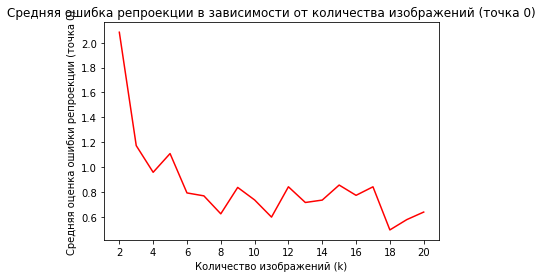

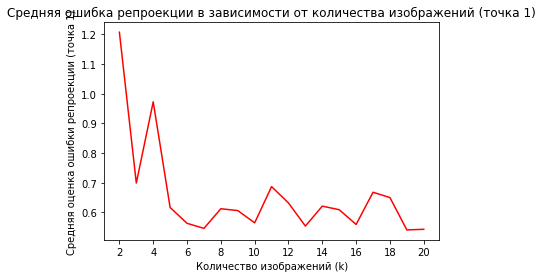

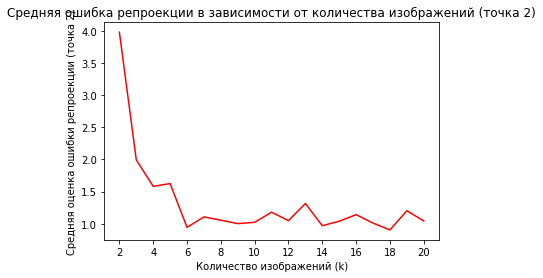

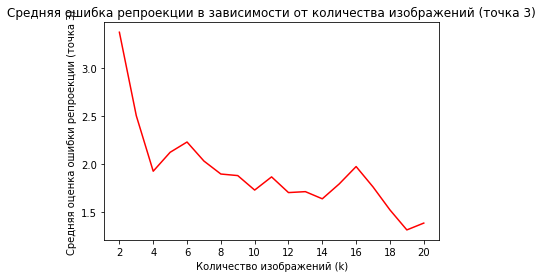

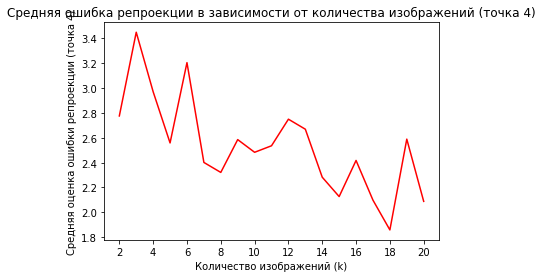

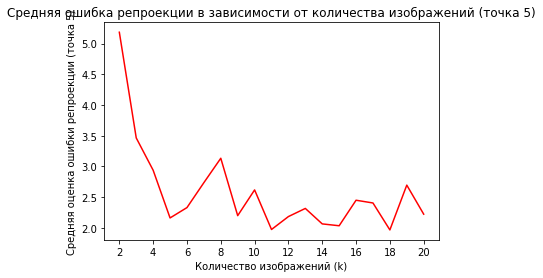

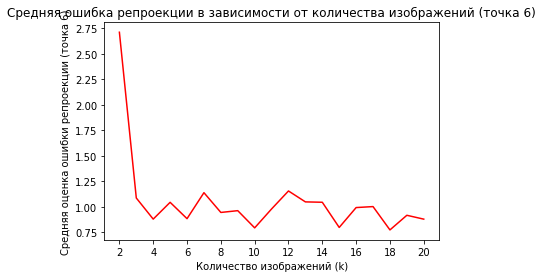

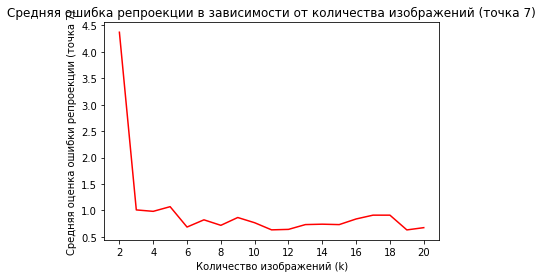

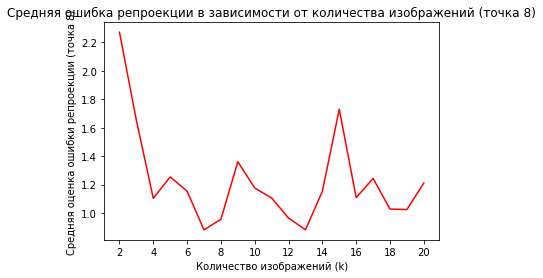

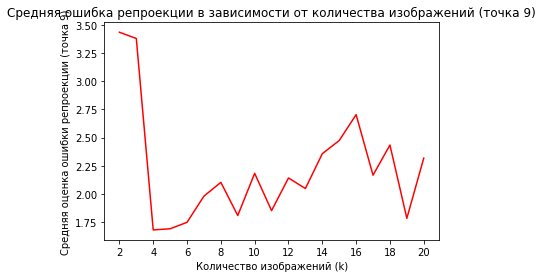

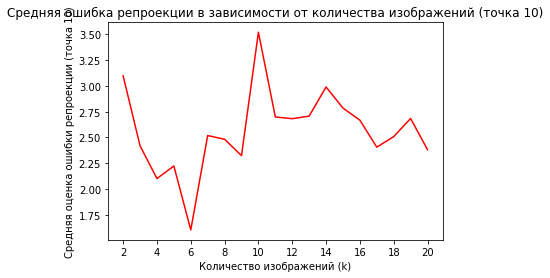

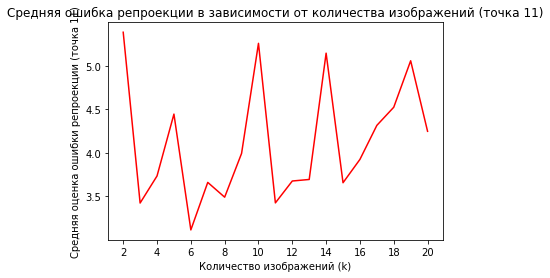

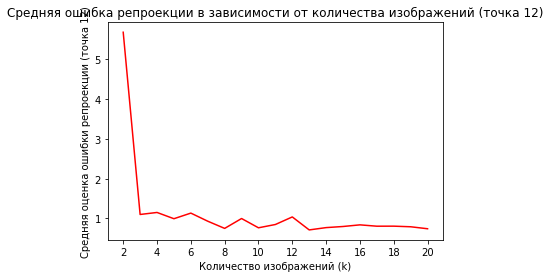

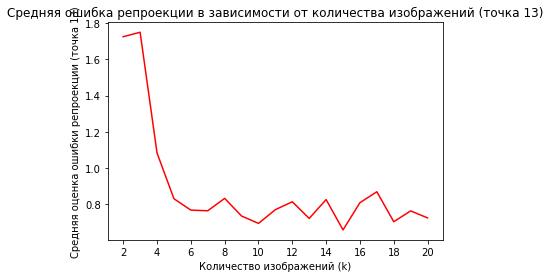

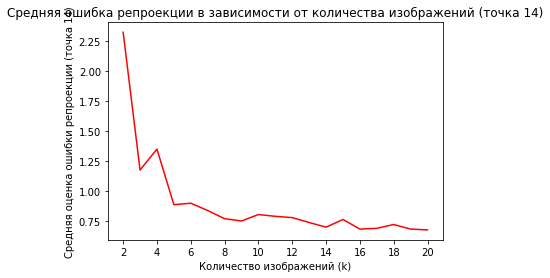

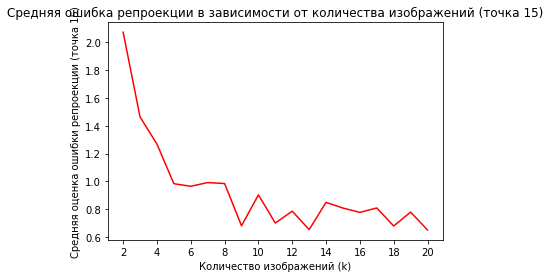

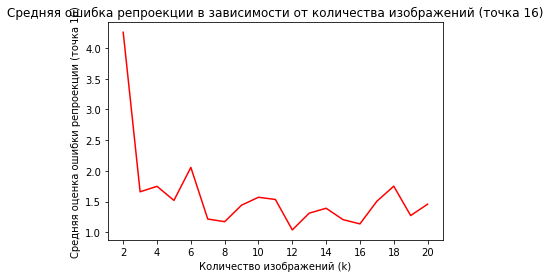

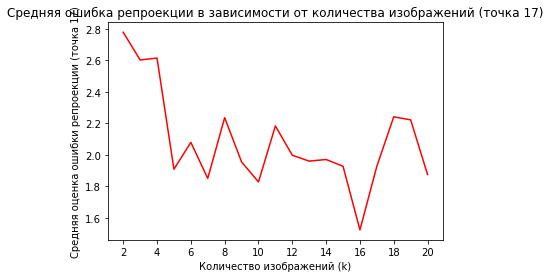

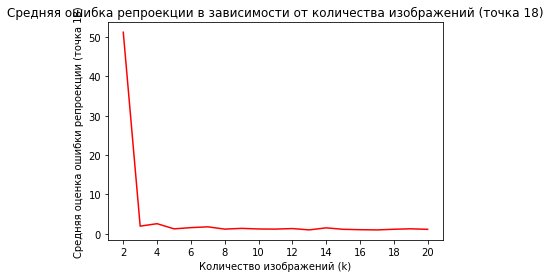

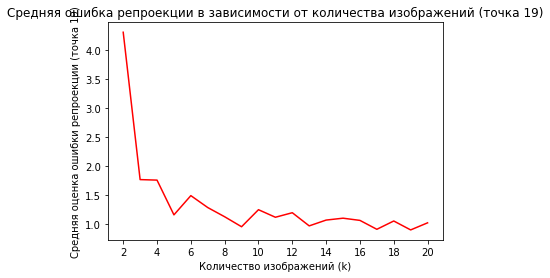

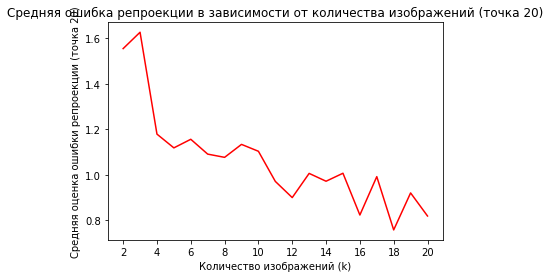

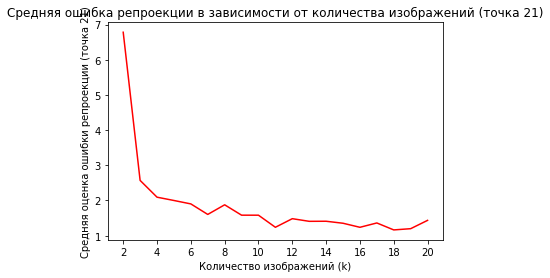

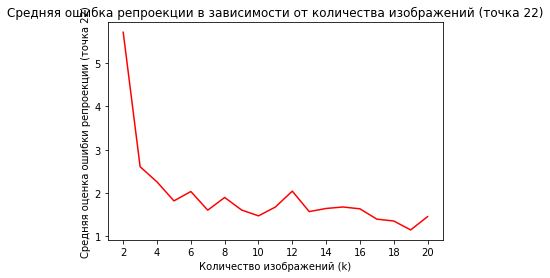

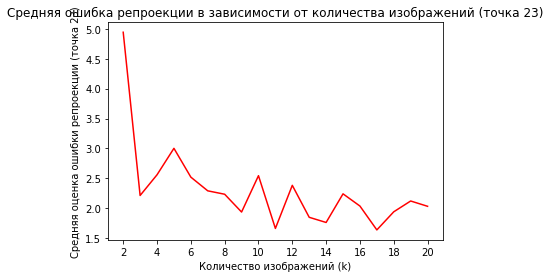

In [178]:
for point_index in stats.keys():
    image_count_in_algo = list(stats[point_index].keys())
    mean_error_values = [sum(value) / len(value) for value in stats[point_index].values()]

    plt.rcParams["figure.figsize"] = (6,4)

    # Создайте график
    plt.plot(image_count_in_algo, mean_error_values, 'r')
    plt.xlabel("Количество изображений (k)")
    plt.ylabel("Средняя оценка ошибки репроекции (точка {})".format(point_index))
    plt.title("Средняя ошибка репроекции в зависимости от количества изображений (точка {})".format(point_index))
    plt.xticks(np.arange(min(image_count_in_algo), max(image_count_in_algo)+1, 2.0)) 

    # Отобразите график
    plt.show()

In [162]:
try_count = 10
stats = {}
points_count = len(data[list(data.keys())[0]]['points'])
for point_index in range(points_count):
    stats[point_index] = {}
    for k in range(2, len(data)):
        stats[point_index][k]= []
        for i in range(try_count):
            filenames, to_compare_filename = get_random_keys(data.keys(), k, False)
            point_3d = find_3d_point(data, filenames, point_index)

            img_data, rvec, tvec = get_image_info(data, to_compare_filename)
            # We need only 2d point, rvec and tvec 
            point_for_comparing = get_image_point(img_data, point_index)

            point_in_image = project_3d_to_2d(rvec, tvec, M, point_3d)

            error = norm(point_for_comparing - point_in_image)

            stats[point_index][k].append(error)


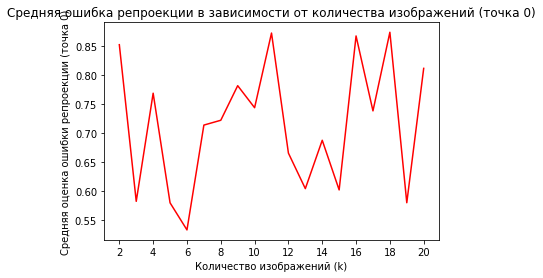

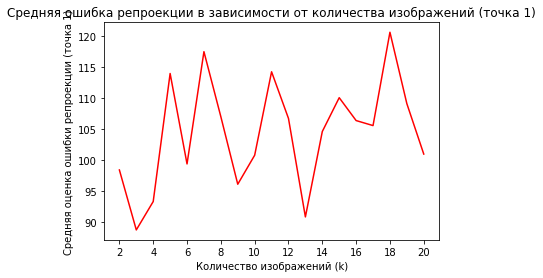

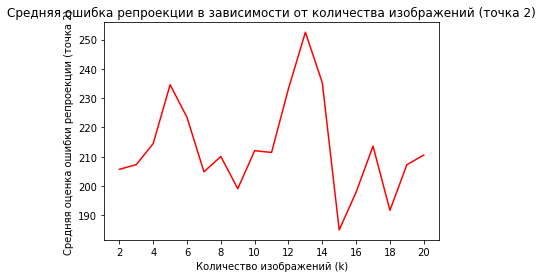

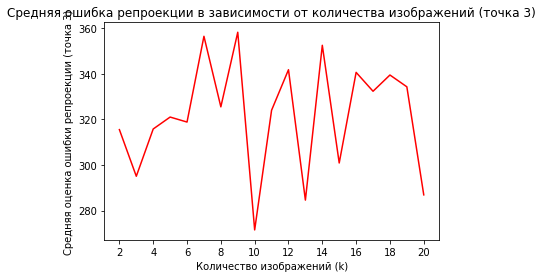

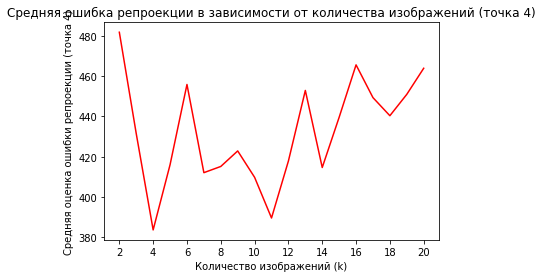

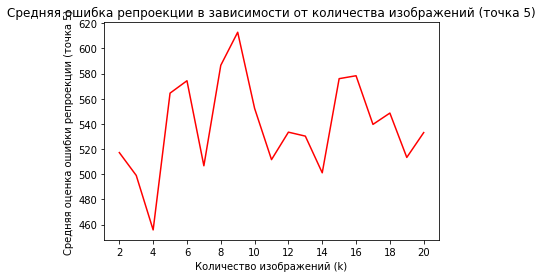

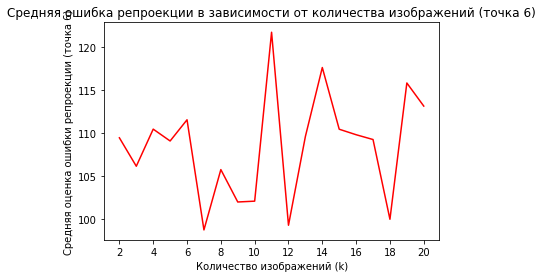

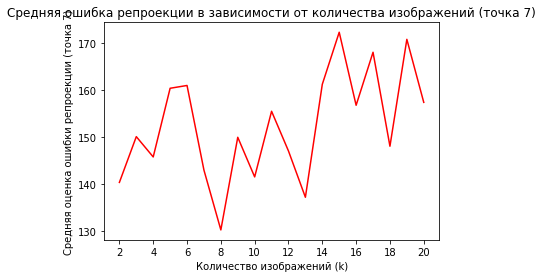

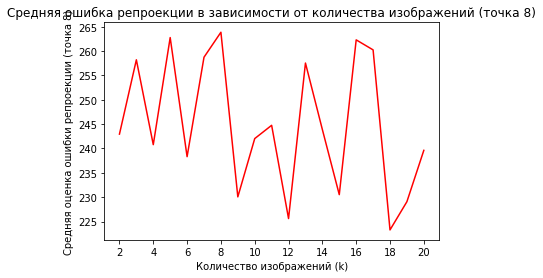

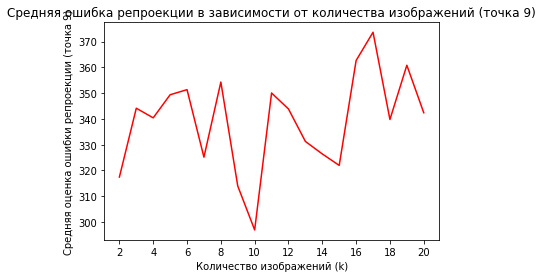

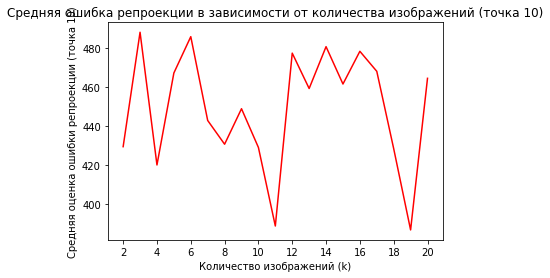

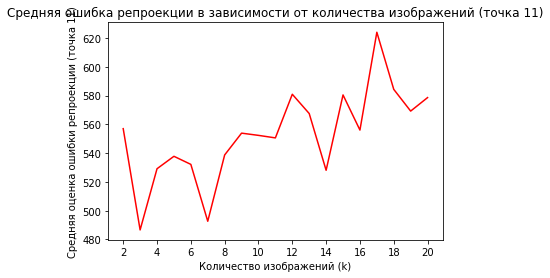

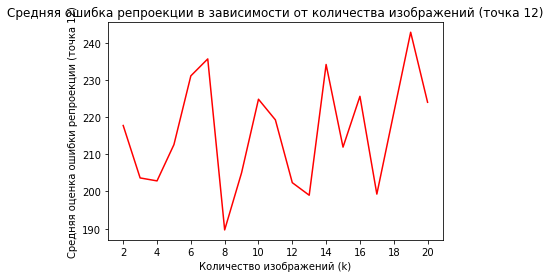

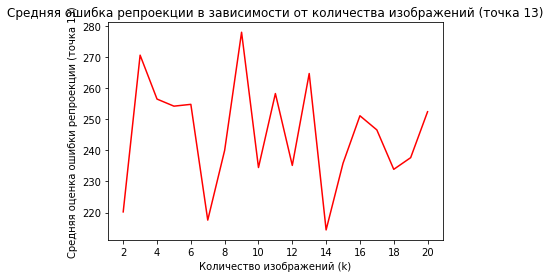

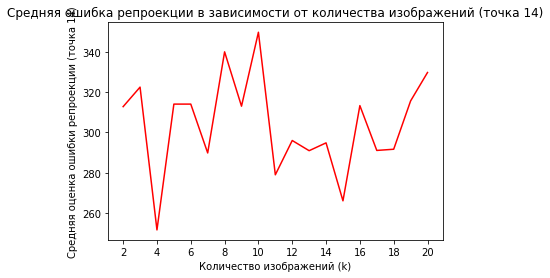

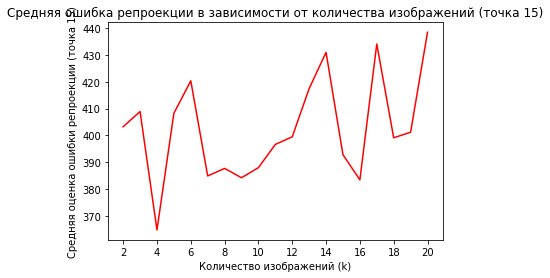

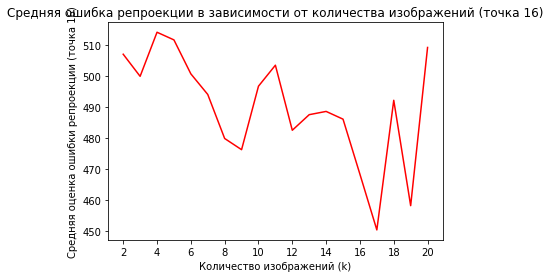

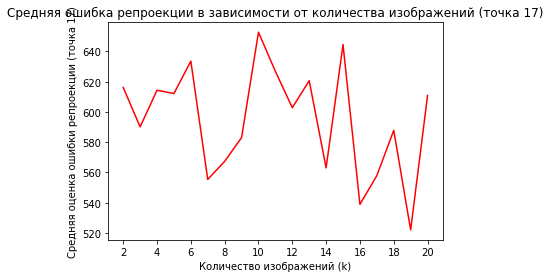

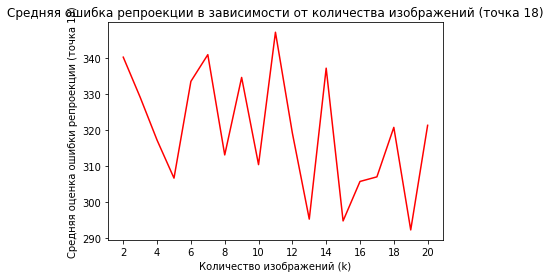

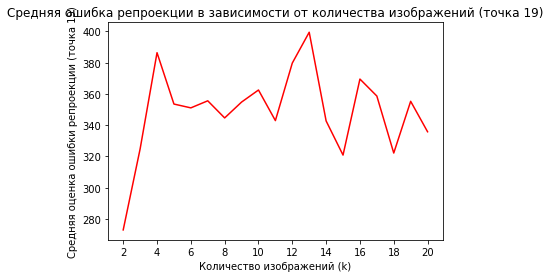

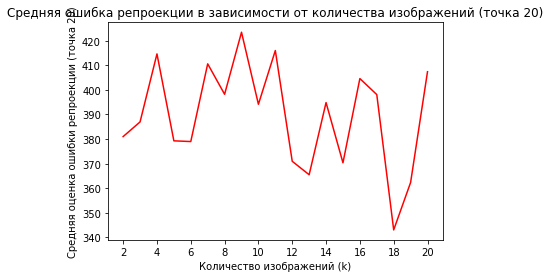

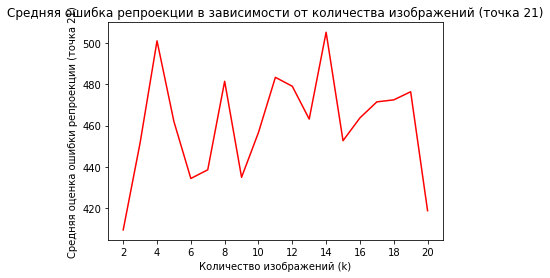

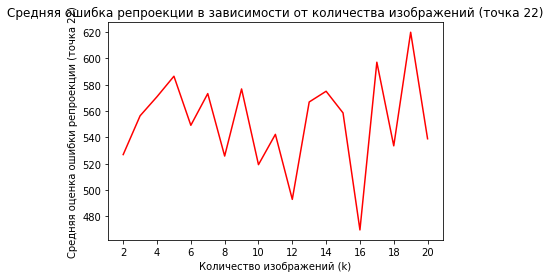

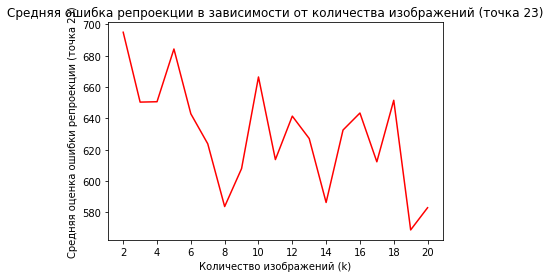

In [163]:
for point_index in stats.keys():
    image_count_in_algo = list(stats[point_index].keys())
    mean_error_values = [sum(value) / len(value) for value in stats[point_index].values()]

    plt.rcParams["figure.figsize"] = (6,4)

    # Создайте график
    plt.plot(image_count_in_algo, mean_error_values, 'r')
    plt.xlabel("Количество изображений (k)")
    plt.ylabel("Средняя оценка ошибки репроекции (точка {})".format(point_index))
    plt.title("Средняя ошибка репроекции в зависимости от количества изображений (точка {})".format(point_index))
    plt.xticks(np.arange(min(image_count_in_algo), max(image_count_in_algo)+1, 2.0)) 

    # Отобразите график
    plt.show()

## Find all 3D point by all images

In [181]:
points_3d = []
for point_index in range(len(data[list(data.keys())[0]]["points"])):
    filenames, to_compare_filename = get_random_keys(data.keys(), k, with_test = False)
    points_3d.append(find_3d_point(data, filenames, point_index))

In [155]:
len(range(len(data[list(data.keys())[0]]["points"])))

24

In [156]:
points_3d

[array([ 0.00000000e+00,  6.38758659e-19, -1.65786352e-17]),
 array([ 0.00000000e+00,  9.28757464e-19, -2.67561097e-17]),
 array([ 0.00000000e+00, -2.77724920e-19,  7.42690248e-18]),
 array([ 0.00000000e+00,  1.31260126e-18, -4.24018053e-17]),
 array([ 0.00000000e+00,  1.05333748e-18, -2.86976366e-17]),
 array([ 0.00000000e+00, -7.58025609e-19,  2.13953253e-17]),
 array([ 0.00000000e+00,  6.68164464e-17, -3.48237238e-15]),
 array([ 0.00000000e+00, -2.89931591e-16,  2.46043740e-14]),
 array([ 0.00000000e+00, -2.48352415e-16,  1.58340699e-14]),
 array([ 0.00000000e+00, -1.43149788e-16,  1.44760956e-14]),
 array([ 0.00000000e+00, -2.03105204e-16,  2.57585886e-14]),
 array([ 0.00000000e+00, -1.45090322e-16,  5.88315840e-15]),
 array([ 0.00000000e+00, -4.44005389e-16, -2.44266866e-14]),
 array([ 0.00000000e+00,  1.15192933e-17, -9.60490867e-15]),
 array([ 0.00000000e+00, -2.74584328e-16, -1.60942360e-14]),
 array([0.00000000e+00, 1.25087055e-16, 2.60299044e-15]),
 array([ 0.00000000e+00,  1

In [182]:
img_name = "GOPR0045.JPG"
img_data, rvec, tvec = get_image_info(data, img_name)
# We need only 2d point, rvec and tvec 
points_2d = []

for point_3d in points_3d:
    point_test = project_3d_to_2d(rvec, tvec, M, point_3d)
    points_2d.append(point_test.tolist()[0][0])
print_point_in_image(points_2d, f"dataset/{img_name}", "result-2-help-vec", radius=3)

In [159]:
points_2d

[[2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.9713414384987, 2385.2046445864225],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.9713414384996, 2385.2046445864216],
 [2978.9713414384987, 2385.204644586423],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422],
 [2978.971341438499, 2385.204644586422]]

In [ ]:
filename = 'points_3d.txt'
with open(filename, "w") as f:
    for ndarray in points_3d:
        np.savetxt(f, ndarray)
        f.write("\n")

In [ ]:
np.save('points_3d.npy', np.array(points_3d)) 

### Точки из датасет

In [ ]:
print_point_in_image(point_in_image.tolist()[0][0], f"dataset/{img_name}", radius=1)

## Оптимизация RT